In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
from datetime import date

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import kneighbors_graph,KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")
plt.style.use(['dark_background'])
np.random.seed(0)

### Read Data

In [2]:
rawdata = pd.read_csv("rawratios.csv")
rawdata.drop(["adate","public_date"],inplace=True,axis=1)
rawdata["Qyear"]=rawdata["qdate"].map(lambda x: int(str(x)[:4]))
ratdesc = pd.read_csv("ratdesc.csv")
ratdesc.set_index("Variable Name",inplace=True)
compdesc = pd.read_csv("compnames.csv")
compdesc.columns=["permno","compname"]
compdesc.set_index("permno",inplace=True)

### Modify Data

In [3]:
basedata = rawdata[(rawdata["Qyear"]>=2014) & (rawdata["Qyear"]<=2016)]
basedata = basedata.groupby(["permno"]).mean()
basedata.drop(["qdate","Qyear"],axis=1, inplace = True)
basedata = basedata.fillna(basedata.mean())

In [4]:
basedata.head(3)

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
permno,,,,,,,,,,,,,,,,,,,,,
10026,34.227611,0.310750,13.316333,28.899333,29.099944,29.129639,29.129639,2.184139,19.699917,0.342750,...,10.730083,1.650583,1.653083,4.767417,0.001,0.004167,0.0,0.047500,3.291417,3.738944
10032,17.910389,0.602500,10.061917,15.565583,15.980111,17.036444,17.036444,0.574611,-9.010389,0.000000,...,5.995667,2.366833,3.092583,3.505917,0.000,0.000000,0.0,0.019750,1.715639,2.357121
10044,19.963917,0.282083,10.391667,16.419306,17.126806,17.904083,17.904083,1.731472,10.525972,0.671667,...,14.221417,1.639500,2.128667,4.686083,0.000,0.009667,0.0,0.081333,3.538833,0.997222


In [5]:
sec_forrec = rawdata[rawdata["Qyear"]==2017].permno.unique()
sec_inbasedata = np.array(basedata.index.unique())
sec_testlist=[]
for item in sec_forrec:
    if item not in sec_inbasedata:
        sec_testlist.append(item)
print("Number of items for testing:",len(sec_testlist))
print("Number of items for clustering:",basedata.shape[0])


Number of items for testing: 140
Number of items for clustering: 1831


### Scaler

In [6]:
scaler = MinMaxScaler((0,1))
basedatasc = scaler.fit_transform(basedata)

In [7]:
basedatasc.shape

(1831, 68)

### PCA & TNSE

PCA

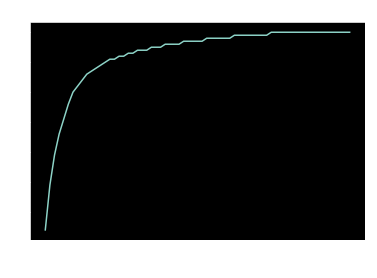

14 variables is sufficient to explain 0.9 of data.


In [8]:
varper=0.90
pcaexpvar =[]
pcano =[]
for i in range(1,basedatasc.shape[1]):
    pca = PCA(n_components=i)
    pca.fit(basedatasc)  
    pcaexpvar.append(round(sum(pca.explained_variance_ratio_),2))
    pcano.append(i)
    
    
plt.plot(pcano,pcaexpvar)
plt.title("PCA Explained Variance Ratio")
plt.xlabel("Number of Variables")
plt.show()
print(pcaexpvar.index(varper)+1,"variables is sufficient to explain",varper,"of data.")

In [9]:
pca = PCA(n_components=pcaexpvar.index(varper)+1)
pcadata = pca.fit_transform(basedatasc)

In [10]:
pcadata.shape

(1831, 14)

TSNE

In [11]:
tsne = TSNE(n_components=3,random_state=0)
tsne.fit(pcadata)
tsnedata = tsne.fit_transform(pcadata)

In [12]:
x_tsne=tsnedata[:,0]
y_tsne=tsnedata[:,1]
z_tsne=tsnedata[:,2]

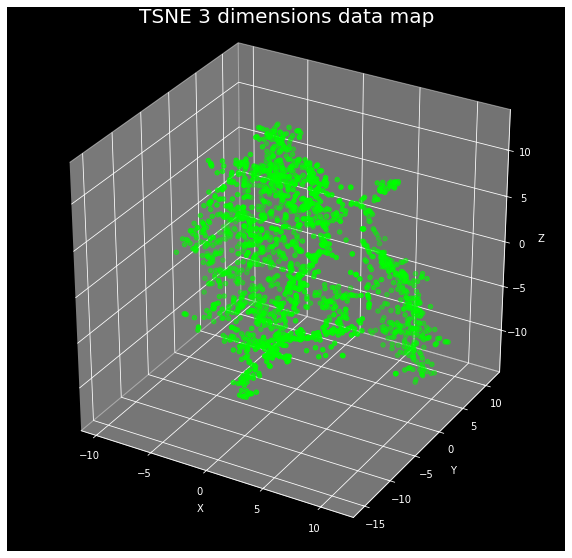

In [13]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_tsne, y_tsne, z_tsne, c="#00FF00")
plt.title("TSNE 3 dimensions data map\n",fontsize=20)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.savefig("TSNE3D.png",quality=100)
plt.show()

### Clustering

Kmeans

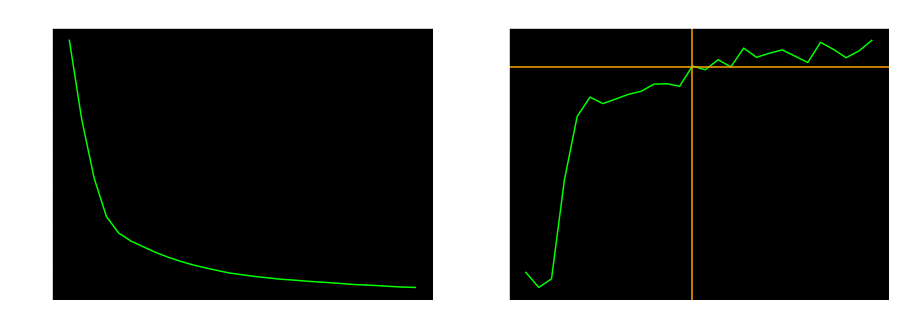

In [14]:
inertiano=[]
inertiaval=[]
inertiachg=[]
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(tsnedata)
    inertiano.append(i)
    inertiaval.append(kmeans.inertia_)
    if i!=1:
        inertiachg.append(inertiaval[i-1]/inertiaval[i-2]-1)
    if i==1:
        inertiachg.append(0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(inertiano,inertiaval,c="#00FF00")
plt.title("Inertia Elbow",fontsize=20)
plt.subplot(122)
plt.plot(inertiano[1:30],inertiachg[1:30],c="#00FF00")
plt.title("Inertia Change %",fontsize=20)
plt.axvline(15,c="orange")
plt.axhline(-0.055,c="orange")
plt.savefig("INERTIA3D.png",quality=100)
plt.show()


In [15]:
kmeansnoclus=15
kmeans = KMeans(n_clusters=kmeansnoclus, random_state=0).fit(tsnedata)

In [16]:
kmeansdata = pd.DataFrame(np.concatenate((tsnedata,np.array(kmeans.labels_).
                                          reshape(-1,1)),axis=1),columns=["x","y","z","label"])

In [17]:
kmeansdata["permno"]=basedata.index
kmeansdata.set_index("permno",inplace = True)

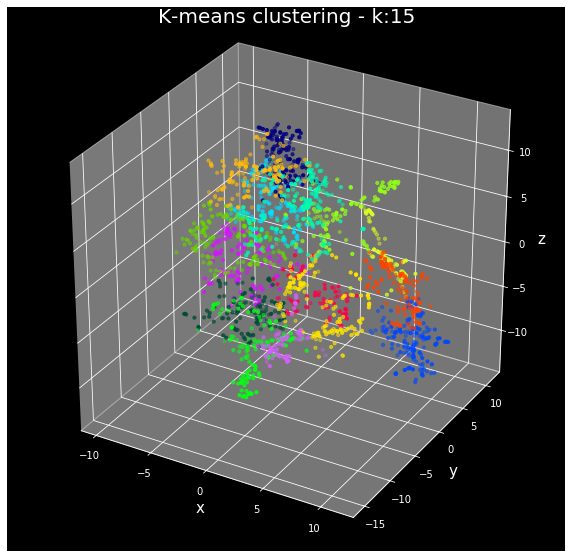

In [18]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
cmap = matplotlib.cm.get_cmap('gist_ncar')
for i in range(kmeansnoclus):
    d_temp=kmeansdata[kmeansdata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    z_temp=d_temp.loc[:,"z"]
    ax.scatter(x_temp, y_temp, z_temp, color=cmap(i/(kmeansnoclus+1)),s=10)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y',fontsize=15)
ax.set_zlabel('z',fontsize=15)
plt.title("K-means clustering - k:"+str(kmeansnoclus)+"\n",fontsize=20)
plt.savefig("KMEANS3D.png",quality=100)
plt.show()

In [19]:
#kmeansdata.groupby("label").count().to_csv("KMclustering3d.csv")

### DBScan 

cluster: 5 noise: 1809 eps: 0.3 minpts: 5
cluster: 5 noise: 1757 eps: 0.8 minpts: 10
cluster: 21 noise: 1405 eps: 1.3 minpts: 15
cluster: 25 noise: 693 eps: 1.8 minpts: 20
cluster: 10 noise: 232 eps: 2.3 minpts: 25
cluster: 4 noise: 47 eps: 2.8 minpts: 30


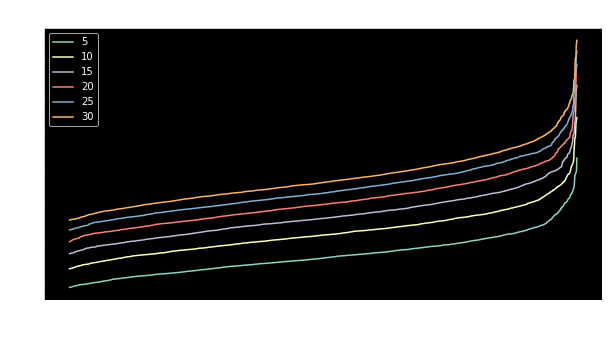

In [20]:
minptslist=[5,10,15,20,25,30]
plt.figure(figsize=(10,5))
for minpts in minptslist:
    neighbourdist = kneighbors_graph(tsnedata, n_neighbors=minpts,mode="distance",
                                     metric="euclidean", n_jobs=-1)
    avgdistlist=[]
    for i in range(neighbourdist.shape[0]):
      avgdist=np.array(-np.sort(-neighbourdist[i].todense()))[0,:minpts].mean()
      avgdistlist.append(avgdist)

    avgdistlist = sorted(avgdistlist)

    plt.plot(range(100,neighbourdist.shape[0]),avgdistlist[100:],label=minpts)
    plt.xlabel("Number of Samples")
    plt.ylabel("Avg Distance")
    plt.title("MinPTS vs Eps",fontsize = 20)
    
    epsval=0.3+0.5*minptslist.index(minpts)
    dbscan = DBSCAN(eps=epsval, min_samples=minpts,metric="euclidean").fit(tsnedata)
    dbscanlabels= len(np.unique(dbscan.labels_))
    dbscannoise=  np.count_nonzero(dbscan.labels_ == -1)
    print ("cluster:",dbscanlabels,"noise:",dbscannoise,"eps:",epsval,"minpts:",minpts)
plt.legend()
plt.savefig("EPSMINPTS3D.png",quality=100)
plt.show()

In [21]:
dbscan = DBSCAN(eps=2.3, min_samples=25).fit(tsnedata)

In [22]:
dbscandata = pd.DataFrame(np.concatenate((tsnedata,np.array(dbscan.labels_).
                                          reshape(-1,1)),axis=1),columns=["x","y","z","label"])


In [23]:
print("Number of clusters:",len(np.unique(dbscan.labels_)))

Number of clusters: 10


In [24]:
dbscandata.head(3)

,x,y,z,label
0,-4.054025,5.375693,-3.604309,0.0
1,-3.028633,5.441687,2.083530,0.0
2,-1.536837,5.289088,2.712559,0.0


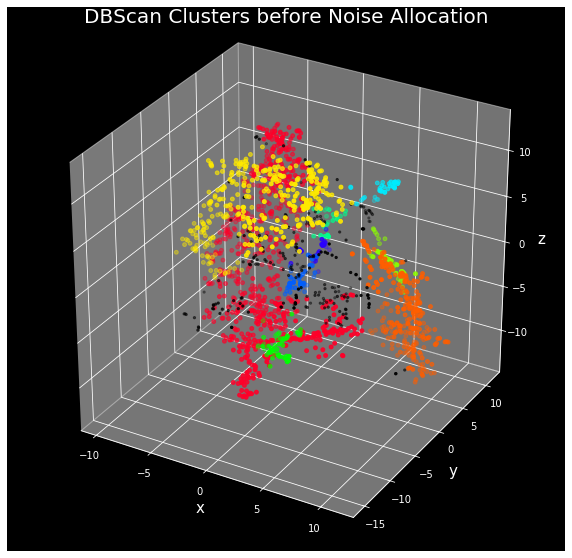

In [25]:
dbscanclus=list((dbscandata["label"].unique().astype("int")))
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
cmap = matplotlib.cm.get_cmap('gist_rainbow')
for i in dbscanclus:
    d_temp=dbscandata[dbscandata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    z_temp=d_temp.loc[:,"z"]
    if i!=-1:
        ax.scatter(x_temp, y_temp, z_temp, color=cmap(i/(len(dbscanclus))),s=15)
    if i==-1:
        ax.scatter(x_temp, y_temp, z_temp, color="black",s=5)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y',fontsize=15)
ax.set_zlabel('z',fontsize=15)
plt.title("DBScan Clusters before Noise Allocation\n",fontsize=20)
plt.savefig("DBSCAN3D N.png",quality=100)
plt.show()

In [26]:
#### Allocate the Noise to Clusters

In [27]:
dbstemp = dbscandata[dbscandata["label"]!=-1]
X = dbstemp[["x","y","z"]]
y= dbstemp["label"]

In [28]:
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [29]:
dbsnoise=dbscandata[dbscandata["label"]==-1]
Xnoise = dbsnoise[["x","y","z"]]
ypredict = clf.predict(Xnoise)

In [30]:
count=0
for item in dbsnoise.index:
    dbscandata.loc[item,"label"]=int(ypredict[count])
    count+=1

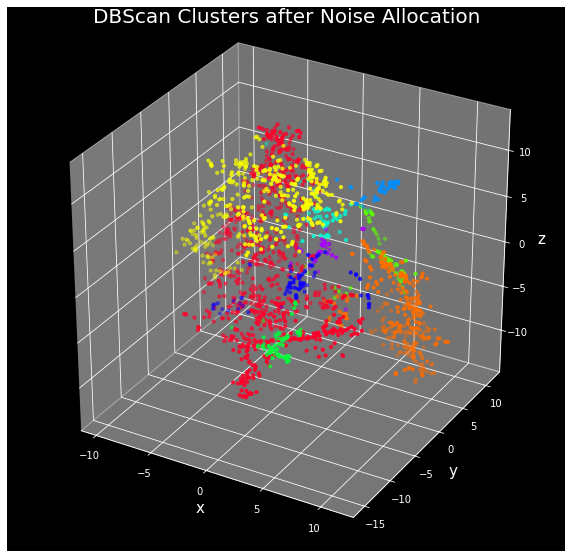

In [31]:
dbscanclus=list((dbscandata["label"].unique().astype("int")))
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
cmap = matplotlib.cm.get_cmap('gist_rainbow')
for i in dbscanclus:
    d_temp=dbscandata[dbscandata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    z_temp=d_temp.loc[:,"z"]
    if i!=-1:
        ax.scatter(x_temp, y_temp, z_temp, color=cmap(i/(len(dbscanclus))),s=10)
    if i==-1:
        ax.scatter(x_temp, y_temp, z_temp, color="black",s=50)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y',fontsize=15)
ax.set_zlabel('z',fontsize=15)
plt.title("DBScan Clusters after Noise Allocation\n",fontsize=20)
plt.savefig("DBSCAN3D.png",quality=100)
plt.show()

In [32]:
dbscandata[dbscandata["label"]==-1]

,x,y,z,label


In [33]:
dbscandata["permno"]=basedata.index
dbscandata.set_index("permno",inplace = True)

In [34]:
dbscandata.head()

,x,y,z,label
permno,,,,
10026,-4.054025,5.375693,-3.604309,0.0
10032,-3.028633,5.441687,2.083530,0.0
10044,-1.536837,5.289088,2.712559,0.0
10107,2.808466,8.610085,1.896790,3.0
10138,3.218351,1.202535,-6.735150,1.0


In [35]:
#dbscandata.groupby("label").count().to_csv("dbsclustering3d.csv")

### Prediction of Labels for 2018 shares - DBScan

In [36]:
X_base = pd.DataFrame(basedatasc,index=basedata.index)
y_base = dbscandata["label"]
clf_base =RandomForestClassifier(random_state =0,max_depth=50,n_estimators=10)
#clf_base =GradientBoostingClassifier(random_state = 0)
#clf_base = IsolationForest()
clf_base.fit(X_base, y_base)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
preddata = rawdata[rawdata["permno"].isin(sec_testlist)]
preddata = preddata.groupby(["permno"]).mean()
preddata.drop(["qdate","Qyear"],axis=1, inplace = True)
preddata = preddata.fillna(preddata.mean())

In [38]:
preddata.shape

(140, 68)

In [39]:
preddatasc = scaler.transform(preddata)
y_predict = (clf_base.predict(preddatasc))
y_preddf=pd.DataFrame(index=preddata.index)
y_preddf["pred"]=y_predict

### Prediction of Labels for 2018 shares - Kmeans

In [40]:
X_basekm = pd.DataFrame(basedatasc,index=basedata.index)
y_basekm = kmeansdata["label"]
clf_basekm =RandomForestClassifier(random_state =0,max_depth=50,n_estimators=10)
#clf_basekm =GradientBoostingClassifier(random_state = 0)
#clf_basekm = IsolationForest()
clf_basekm.fit(X_basekm, y_basekm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [41]:
preddatakm = rawdata[rawdata["permno"].isin(sec_testlist)]
preddatakm = preddatakm.groupby(["permno"]).mean()
preddatakm.drop(["qdate","Qyear"],axis=1, inplace = True)
preddatakm = preddatakm.fillna(preddatakm.mean())

In [42]:
preddatasckm = scaler.transform(preddatakm)
y_predictkm = (clf_basekm.predict(preddatasckm))
y_preddfkm=pd.DataFrame(index=preddatakm.index)
y_preddfkm["pred"]=y_predictkm

### Security Prices

In [43]:
pricedataraw = pd.read_csv("prices2.csv")
pricedata = pricedataraw.join(pricedataraw["date"].str.split(pat="/",expand=True))
pricedata.columns=(["permno","date","prc","day","month","year"])
pricedata["prc"]=pricedata["prc"].fillna(value=0)
seclist = pricedata["permno"].unique()

In [44]:
pricedata = (pricedata.groupby(["year","permno"]).mean())
pricedata = pricedata.reset_index()
pricedata17 = pricedata[pricedata["year"]=="2017"]
pricedata18 = pricedata[pricedata["year"]=="2018"]
pricedata17.set_index("permno",inplace=True)
pricedata18.set_index("permno",inplace=True)

DBScan

In [45]:
y_preddf2 = y_preddf.join(pricedata17["prc"])
y_preddf2.columns=["cluster","2017avg"]
y_preddf2 = y_preddf2.join(pricedata18["prc"])
y_preddf2.columns=["cluster","2017avg","2018avg"]
y_preddf2 = y_preddf2[y_preddf2["2018avg"].notna()]
y_preddf2 = y_preddf2[y_preddf2["2017avg"].notna()]

In [46]:
clusters = pd.DataFrame(index=dbscandata.index)
clusters["cluster"]=dbscandata["label"]
clusterreturns = clusters.join(pricedata17["prc"])
clusterreturns.columns=["cluster","2017avg"]
clusterreturns = clusterreturns.join(pricedata18["prc"])
clusterreturns.columns=["cluster","2017avgC","2018avgC"]
clusterreturnssum = clusterreturns.groupby("cluster").mean()

In [47]:
y_preddffinal = y_preddf2.join(clusterreturnssum,on="cluster")

In [48]:
y_preddffinal["secreturn"]=y_preddffinal["2018avg"]/y_preddffinal["2017avg"]-1
y_preddffinal["clusreturn"]=y_preddffinal["2018avgC"]/y_preddffinal["2017avgC"]-1
y_preddffinal["nasdaqreturn"]=7425.98/6235.29-1
y_preddffinal["clusdif"]=abs(y_preddffinal["secreturn"]-y_preddffinal["clusreturn"])
y_preddffinal["indexdif"]=abs(y_preddffinal["secreturn"]-y_preddffinal["nasdaqreturn"])
print("Difference with CLusters",y_preddffinal["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinal["indexdif"].mean())
print("Improvement",-(y_preddffinal["clusdif"].mean()/y_preddffinal["indexdif"].mean()-1))

Difference with CLusters 0.3134322159045387
Difference with Nasdaq Index 0.3443057835384096
Improvement 0.08966903581050878


In [49]:
y_preddffinal["clusdif"]=(y_preddffinal["secreturn"]-y_preddffinal["clusreturn"])
y_preddffinal["indexdif"]=(y_preddffinal["secreturn"]-y_preddffinal["nasdaqreturn"])
print("Difference with CLusters",y_preddffinal["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinal["indexdif"].mean())
print("Improvement",-(y_preddffinal["clusdif"].mean()/y_preddffinal["indexdif"].mean()-1))


Difference with CLusters -0.09935484297016316
Difference with Nasdaq Index -0.16105461672843224
Improvement 0.3830984482879263


In [50]:
#y_preddffinal.groupby("cluster").count().to_csv("DBSpredictiondist3d.csv")

Kmeans

In [51]:
y_preddf2km = y_preddfkm.join(pricedata17["prc"])
y_preddf2km.columns=["cluster","2017avg"]
y_preddf2km = y_preddf2km.join(pricedata18["prc"])
y_preddf2km.columns=["cluster","2017avg","2018avg"]
y_preddf2km = y_preddf2km[y_preddf2km["2018avg"].notna()]
y_preddf2km = y_preddf2km[y_preddf2km["2017avg"].notna()]

In [52]:
clusterskm = pd.DataFrame(index=kmeansdata.index)
clusterskm["cluster"]=kmeansdata["label"]
clusterreturnskm = clusterskm.join(pricedata17["prc"])
clusterreturnskm.columns=["cluster","2017avg"]
clusterreturnskm = clusterreturnskm.join(pricedata18["prc"])
clusterreturnskm.columns=["cluster","2017avgC","2018avgC"]
clusterreturnskmsum = clusterreturnskm.groupby("cluster").mean()

In [53]:
y_preddffinalkm = y_preddf2km.join(clusterreturnskmsum,on="cluster")

In [54]:
y_preddffinalkm["secreturn"]=y_preddffinalkm["2018avg"]/y_preddffinalkm["2017avg"]-1
y_preddffinalkm["clusreturn"]=y_preddffinalkm["2018avgC"]/y_preddffinalkm["2017avgC"]-1
y_preddffinalkm["nasdaqreturn"]=7425.98/6235.29-1
y_preddffinalkm["clusdif"]=abs(y_preddffinalkm["secreturn"]-y_preddffinalkm["clusreturn"])
y_preddffinalkm["indexdif"]=abs(y_preddffinalkm["secreturn"]-y_preddffinalkm["nasdaqreturn"])
print("Difference with CLusters",y_preddffinalkm["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinalkm["indexdif"].mean())
print("Improvement",-(y_preddffinalkm["clusdif"].mean()/y_preddffinalkm["indexdif"].mean()-1))

Difference with CLusters 0.3485575567349718
Difference with Nasdaq Index 0.3443057835384096
Improvement -0.012348828860401229


In [55]:
y_preddffinalkm["clusdif"]=(y_preddffinalkm["secreturn"]-y_preddffinalkm["clusreturn"])
y_preddffinalkm["indexdif"]=(y_preddffinalkm["secreturn"]-y_preddffinalkm["nasdaqreturn"])
print("Difference with CLusters",y_preddffinalkm["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinalkm["indexdif"].mean())
print("Improvement",-(y_preddffinalkm["clusdif"].mean()/y_preddffinalkm["indexdif"].mean()-1))

Difference with CLusters -0.1532304340246592
Difference with Nasdaq Index -0.16105461672843224
Improvement 0.0485809277790904


In [56]:
#y_preddffinalkm.groupby("cluster").count().to_csv("KMpredictiondist3d.csv")

### Recommendation

In [57]:
cossim= pd.DataFrame(cosine_similarity(basedata),index=basedata.index,columns=basedata.index)
for rw in cossim.index:
    cossim.loc[rw,rw]=0

In [58]:
recomdf=pd.DataFrame(index=cossim.index,columns=["recomno","sim","cl1","cl2"])

for row in cossim.index:
    check=0
    while check==0:
        maxval = cossim.loc[row,:].max()
        
        rowserie = cossim.loc[row,:]
        col= rowserie[rowserie==maxval].index[0]
        if dbscandata.loc[row,"label"]!=dbscandata.loc[col,"label"]:
            recomdf.loc[row,"recomno"]=int(col)
            recomdf.loc[row,"sim"]=float(cossim.loc[row,col])
            recomdf.loc[row,"cl1"]=dbscandata.loc[row,"label"]
            recomdf.loc[row,"cl2"]=dbscandata.loc[col,"label"]
            check=1
        else:
            cossim.loc[row,col]=0
            check=0

recomdf["recomno"]=recomdf["recomno"].astype(int)

In [59]:
recommendation = recomdf.join(compdesc,on="recomno")

In [60]:
recommendation.head()

,recomno,sim,cl1,cl2,compname
permno,,,,,
10026,13046,0.995385,0,2,UBIQUITI NETWORKS INC
10032,76201,0.968507,0,8,XILINX INC
10044,65700,0.983219,0,8,UNITED STATES LIME MINERALS INC
10107,88167,0.942145,3,0,HEALTHSTREAM INC
10138,75517,0.996502,1,2,MARTEN TRANSPORT LTD
